In [1]:
%matplotlib inline 
import pandas as pd 
import numpy as np 
import copy 
import pylab as pl 
from string import Template

# Noise according to Potter

The noise is assumed to be multiplicative. $X_m$ is the measurement, its error can be expressed as:

$Xm = X\cdot S$

$S$ is a random variable independent of $X$ assumed to have a log-normal distribution with $E[S] = 1$ and $V[s]=\sigma^2$. If $T=ln(S)$, then $T$ has a normal distribution with

$E[T] = \frac{1}{2} ln(1+\sigma^2)$

and 

$V[T] = ln(1+\sigma^2)$

Data from Riggs (1976) suggest that $\sigma^2$ is equal to **0.16**. Additional data suggest a value of **0.3**.


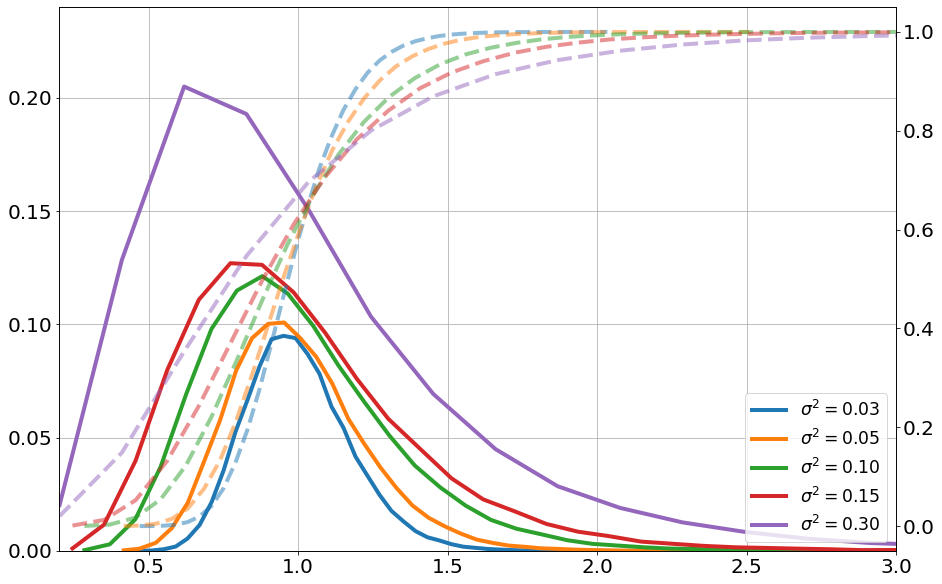

In [5]:
sigma2 = 0.03
fig = pl.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
for sigma2 in [0.03,0.05,0.1,0.15,0.3]:
    Et = -0.5*np.log(1+sigma2) #Sigma can also be 0.3
    Vt = np.log(1+sigma2)
    a = np.exp(np.random.normal(Et, np.sqrt(Vt), 100000))
    h, b = np.histogram(a, bins = 40,)
    h = h.astype(float) / h.sum()
    b = (b[:-1]+b[1:])/2
    text = '$\\sigma^2=%.2f$' % sigma2 
    ax.plot(b, h, lw = 4, label = text)
    ax2.plot(b, h.cumsum(), lw = 4, ls = '--',label = text, alpha = 0.5)
ax.set_xlim(0.2,3)
ax.set_ylim(0,0.24)
ax.legend(loc = 4, fontsize = 'xx-large')
ax.tick_params(labelsize = 20)
ax2.tick_params(labelsize = 20)
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.grid()

In [44]:
def fix_year_issue(path,path_out):
    f = open(path,'r')
    l = f.readlines()
    f.close()
    
    year1 = int(l[4:][0].split()[1][:4])
    for c,i in enumerate(l[4:]):
        y = year1+c
        yc = l[c+4].split()[1]
        t = '%d0505' % y
        l[c+4] = l[c+4].replace(yc,t)
        
    f = open(path_out,'w')
    f.writelines(l)
    f.close()
    
def constant_error_case(sigma2 = 0.16):
    '''if Xm are the measurments, the actual flood is X = Xm x S. 
    Here S is a random variable greater than zero distributed lognormal
    E[S] = 1 and V[S] = sigma2. If T = ln(S) then T is normal with the 
    following estimators:'''
    #Taken from Potter and walker 1981
    Et = -0.5*np.log(1+sigma2) #Sigma can also be 0.3
    Vt = np.log(1+sigma2)
    return np.exp(np.random.normal(Et, np.sqrt(Vt), 1))[0]

def qp_noise(path, out_path,out_psf,out_prt,ntimes,skewVal, skewError,sigma2 = 0.16, method = 'B17B',
            error = None):
    '''Reads a peak file from https://nwis.waterdata.usgs.gov/usa/nwis/peak 
    creates a noise following a random function and writes the results 
    to out_path
    if error == None, the function is magnitude indepenedent, otherwise, it computes sigma2 = error*magnitude '''
    
    #Define templates to write the psf file
    header_template = Template('I ASCI $peaks_file\n\
    O File $out_peaks_file\n\
    O ConfInterval 0.9\n\
    O EMA YES\n')
    station_template = Template('Station $station\n\
    Analyze $method\n\
    PCPT_Thresh $year_start $year_end 0 1E+20 Default\n\
    BegYear $year_start\n\
    EndYear $year_end\n\
    HistPeriod $num_years\n\
    SkewOpt Weighted\n\
    UseSkewMap NO\n\
    GenSkew $skewVal\n\
    SkewSE $skewError\n\
    LOType MGBT\n')
    
    #Read the file
    f = open(path,'r')
    l = f.readlines()
    f.close()
    original_id = l[0].split()[0][1:] 
    
    #Gets stgart and end years and num years
    year_end = l[-1].split()[1][:4]
    year_start = l[5].split()[1][:4]
    num_years = len(l[4:-1])+1
    
    #Open the file to write into also opens the psf file
    f = open(out_path,'w')
    f_psf = open(out_psf,'w')
    
    #Writes the header of the psf 
    f_psf.write(header_template.safe_substitute({'peaks_file':out_path,
                                       'out_peaks_file':out_prt}))
    qpeaks = []
    #Creates ntimes series
    for z in range(ntimes):
        #Creates a copy of the orifinal list with the data
        lt = copy.copy(l)
        #Grab the data and not the header    
        a = lt[4:]
        new_id = '%d' % (100000000+z)
        new_id = new_id[1:]
        #Iterates through the data creating some noise
        qp_old = []
        qp_new = []
        for c, i in enumerate(a):
            try:
                #Grab the old record
                #t_old = i.split()[2]
                t_old = i[:31].split()[2]
                #Aplly random noise over the record
                #rn = np.random.normal(1,0.05)[0]
                if error != None:
                    sigma2 = error * float(t_old)
                #print(t_old)
                rn = constant_error_case(sigma2)
                random = float(t_old) * rn
                #Replace the record in the list
                t_new = '%d'% random
                #Check lenghts
                dif_len = len(t_old) - len(t_new)
                if dif_len < 0:
                    for j in range(np.abs(dif_len)):
                        t_old = ' '+t_old
                elif dif_len > 0:
                    for j in range(dif_len):
                        t_new = ' '+t_new
                a[c] = i.replace(t_old, t_new) 
                #Change the height 
                try:
                    t_old2 = i.split()[3]
                    random = float(t_old2) * rn
                    #Replace the record in the list
                    t_new2 = '%.2f'% random
                    a[c] = a[c].replace(t_old2, t_new2)
                except:
                    pass
                qp_old.append(int(t_old))
                qp_new.append(int(t_new))
            except:
                pass
        #Writes the new file 
        lt[4:] = a
        
        #Replace the id of the time series
        for c, i in enumerate(lt):
            lt[c] = i.replace(original_id, new_id)
        f.writelines(lt)
        f.write('\n')
        
        #Updates the psf file 
        f_psf.write(station_template.safe_substitute({'station':new_id,
                                                      'skewVal':skewVal, 
                                                      'skewError':skewError,
                                                     'year_start':year_start,
                                                     'year_end':year_end,
                                                     'num_years':num_years,
                                                     'method':method}))
        #updates the series with noised peak flows 
        qpeaks.append(np.array(qp_new))
    
    f.close()
    return qp_old, qpeaks

In [58]:
def replace(qpeaks, rec_len):    
    #Get the random positions to switch
    pos = np.random.choice(np.arange(0,len(qpeaks)),len(qpeaks), False)
    for p1, p2 in enumerate(pos):
        t1 = qpeaks[p1][24:]
        t2 = qpeaks[p2][24:]
        qpeaks[p1] = qpeaks[p1].replace(t1, t2)
        qpeaks[p2] = qpeaks[p2].replace(t2, t1)
    return qpeaks[:rec_len]

def mutate(qpeaks, sigma2, error = None):
    #Compute the mean and max of the peak flows
    d = []
    for i in qpeaks:
        try:
            d.append(float(i[:31].split()[2]))
        except:
            pass
    d = np.array(d)
    #Do the mutation
    a = copy.copy(qpeaks)
    b= []
    for c, i in enumerate(a):
        try:
            #Grab the old record
            t_old = i[:31].split()[2]
            #Aplly random noise over the record
            if error != None:
                sigma2 = (float(t_old) / d.mean()) * error
            rn = constant_error_case(sigma2)
            random = float(t_old) * rn
            #Replace the record in the list
            t_new = '%d'% random
            #Check lenghts
            dif_len = len(t_old) - len(t_new)
            if dif_len < 0:
                for j in range(np.abs(dif_len)):
                    t_old = ' '+t_old
            elif dif_len > 0:
                for j in range(dif_len):
                    t_new = ' '+t_new
            a[c] = i.replace(t_old, t_new) 
            #Change the height 
            try:            
                t_old2 = i.split()[3]
                random = float(t_old2) * rn
                #Replace the record in the list
                t_new2 = '%.2f'% random
                a[c] = a[c].replace(t_old2, t_new2)
            except:
                pass        
        except:
            pass
    return a

def write_mutated_peaks(path_original, out_path, out_psf,out_prt, rec_len, ntimes, 
                        skewVal, skewError, sigma2=0.16, method = 'EMS', mapSkew = 'NO', add_noise = False,
                       shuffle = True, error = None):
    #Read the original peak flow file
    f = open(path_original,'r')
    l = f.readlines()
    f.close()
    original_id = l[0].split()[0][1:] 
    
    #Define templates to write the psf file
    header_template = Template('I ASCI $peaks_file\n\
        O File $out_peaks_file\n\
        O ConfInterval 0.9\n\
        O EMA YES\n')
    station_template = Template('Station $station\n\
        Analyze $method\n\
        PCPT_Thresh $year_start $year_end 0 1E+20 Default\n\
        BegYear $year_start\n\
        EndYear $year_end\n\
        HistPeriod $num_years\n\
        SkewOpt Weighted\n\
        UseSkewMap $mapSkew\n\
        GenSkew $skewVal\n\
        SkewSE $skewError\n\
        LOType MGBT\n')
    
    #Open the file to write into also opens the psf file
    f = open(out_path,'w')
    f_psf = open(out_psf,'w')
    
    #Writes the header of the psf 
    f_psf.write(header_template.safe_substitute({'peaks_file':out_path,
                                       'out_peaks_file':out_prt}))

    for z in range(ntimes):
        #Grab the data and not the header    
        new_id = '%d' % (100000000+z)
        new_id = new_id[1:]
    
        #Get the mutate peaks         
        if shuffle:
            qpeaks = replace(l[4:], rec_len)
        else:
            qpeaks = l[4:4+rec_len]
        if add_noise:
            qpeaks = mutate(qpeaks, sigma2, error = error)
                        
        #Replace the id of the time series
        lt = l[:4] + qpeaks
        for c, i in enumerate(lt):
            lt[c] = i.replace(original_id, new_id)
        f.writelines(lt)
        f.write('\n')
     
        #Updates the psf file 
        year_start = int(qpeaks[0].split()[1][:4])
        year_end = int(qpeaks[-1].split()[1][:4])
        num_years = year_end - year_start+1
        f_psf.write(station_template.safe_substitute({'station':new_id,
                                                      'skewVal':skewVal, 
                                                      'skewError':skewError,
                                                     'year_start':year_start,
                                                     'year_end':year_end,
                                                     'num_years':num_years,
                                                     'method':method,
                                                     'mapSkew':mapSkew}))
    f.close()
    f_psf.close()
    return qpeaks

# Just adding noise 

In [8]:
def read_prt(path_prt):
    f = open(path_prt,'r')
    l = f.readlines()
    f.close()
    #Find the regresion position in the file
    pos = l.index('PROBABILITY REG SKEW  REG SKEW       OF EST.    5.0% LOWER   95.0% UPPER\n')
    #Read the data
    data = []
    for j in l[pos+2:pos+17]:
        data.append([float(i) for i in j.split()])
    return pd.DataFrame(np.array(data), columns=['prob','w_reg_skew','no_reg_skew','log_var','conf5','conf95'])

In [9]:
def read_prt(path_prt, method = 'EMS'):
    f = open(path_prt,'r')
    l = f.readlines()
    f.close()
    flag = True
    positions = []
    d = []
    while flag:
        try:
            #Find the place with the regression
            if method == 'EMS':
                pos = l.index('PROBABILITY REG SKEW  REG SKEW       OF EST.    5.0% LOWER   95.0% UPPER\n')
            else:
                pos = l.index('PROBABILITY ESTIMATE   RECORD      OF EST.   5.0% LOWER  95.0% UPPER\n')
            positions.append(pos)
            l[pos] = 'changed'

            #Read the data
            if method == 'EMS':
                data = []
                for j in l[pos+2:pos+17]:
                    data.append([float(i) for i in j.split()])
                d.append(pd.DataFrame(np.array(data), columns=['prob','w_reg_skew','no_reg_skew','log_var','conf5','conf95']))
            else:
                data = []
                for j in l[pos+5:pos+17]:
                    t = []
                    for i in j.split():
                        try:
                            t.append(float(i))
                        except:
                            pass
                    data.append(t)
                d.append(pd.DataFrame(np.array(data), columns=['prob','estimate','record','conf5','conf95']))
        except:
            flag = False    
    return d

In [10]:
def plot_freq(do,dn = None):
    fig = pl.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    if dn is not None:
        for d in dn:    
            pl.plot(1-d['prob'], d['conf5']*0.028, lw = 3, c = '#feb24c',zorder=-1)
            pl.plot(1-d['prob'], d['conf95']*0.028, lw = 3, c = '#feb24c',zorder=-1)
        for d in dn:    
            pl.plot(1-d['prob'], d['w_reg_skew']*0.028, lw = 3,c = '#9ecae1',zorder=-1)
    pl.plot(1-do['prob'], do['w_reg_skew']*0.028, lw = 5, c = 'k',zorder=-1)
    pl.plot(1-do['prob'], do['conf5']*0.028, ls = '--',lw = 3, c = 'r',zorder=-1)
    pl.plot(1-do['prob'], do['conf95']*0.028,ls = '--', lw = 3, c = 'r',zorder=-1)
    pl.yscale('log')
    pl.xscale('logit')
    x = 1-do['prob'].values
    ax.set_xlim(x[0],x[-1])
    ax.tick_params(labelsize = 20)
    ax.set_xlabel('Exeedance probability',size = 20)
    ax.set_ylabel('Streamflow [cms]',size = 20)
    ax.grid(which='both')
    return ax

In [11]:
def read_obs(path):
    f = open(path, 'r')
    l = f.readlines()
    f.close()

    to_find1 = '  TABLE 6 - EMPIRICAL FREQUENCY CURVES -- HIRSCH-STEDINGER PLOTTING POSITIONS\n'
    to_find2 = '                    TABLE 7 - EMA REPRESENTATION OF DATA\n'
    pos1 = l.index(to_find1)
    pos2 = l.index(to_find2)

    a = l[pos1+4:pos2-10]
    q = []
    ema = []
    pilf = []
    year = []
    for i in a:    
        try:
            if len(i.split()) == 3:
                year.append(float(i.split()[0]))
                q.append(float(i.split()[2]))
                ema.append(float(i.split()[1]))
                pilf.append(0)
            else:
                year.append(float(i.split()[1]))
                q.append(float(i.split()[3]))
                ema.append(float(i.split()[2]))
                pilf.append(1)
        except:
            pass
    return np.array(ema), np.array(q), np.array(pilf)

## Turkey at Garber 05412500 (4,000 $km^2$) - 103 years of records

Creates the noised version of the records with incremental $\sigma^2$

In [9]:
#fix_year_issue('05412500-turkey.txt','05412500f-turkey.txt')
for c,sigma in enumerate([0.04,0.1,0.16,0.3]):
    qo,qn = qp_noise('05412500f-turkey.txt','turkey_peaks'+str(c)+'.txt',
                 'turkey_noised'+str(c)+'.psf','turkey_noised'+str(c)+'.prt',100,-0.4,0.55,sigma, method = 'EMS')

### Version with sigma changing in function of the peak magnitude 

In [45]:
sigma = 0.16
qo,qn = qp_noise('05412500f-turkey.txt','turkey_peaks_er_dep.txt',
             'turkey_noised_er_dep.psf','turkey_noised_er_dep.prt',100,-0.4,0.55,sigma, method = 'EMS', error = 5e-6)

In [ ]:
a = write_mutated_peaks('05412500f-turkey.txt','turkey_80y_Noise.txt',
             'turkey_noised_er_dep.psf','turkey_noised_er_dep.prt',90,100, -0.4,0.55,sigma, method = 'EMS', error = 0.1)

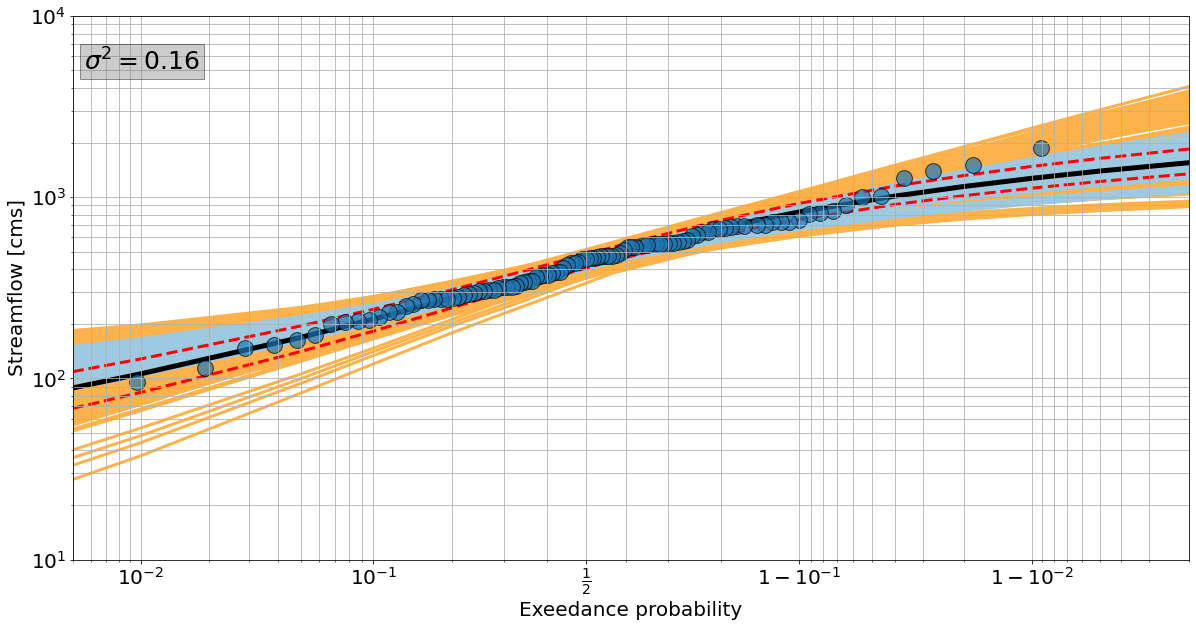

In [60]:
do = read_prt('05412500F-TURKEY.PRT')[0]
q,ema,p = read_obs('05412500F-TURKEY.PRT')
dn = read_prt('TURKEY_NOISED_ER_DEP.PRT')
ax = plot_freq(do, dn)
text = '$\sigma^2 = %.2f$' % sigma
ax.text(0.01,0.9, text, fontdict = {'size': 25, 'weight':'bold'}, transform = ax.transAxes,
    bbox=dict(facecolor='gray', alpha=0.4)) 
ax.set_ylim(10e0, 10e3)    
ax.scatter(1-ema, q*0.028, s = 250, edgecolor = 'k', zorder = 1, alpha = 0.7)

Plot results from versions with different levels of noise 

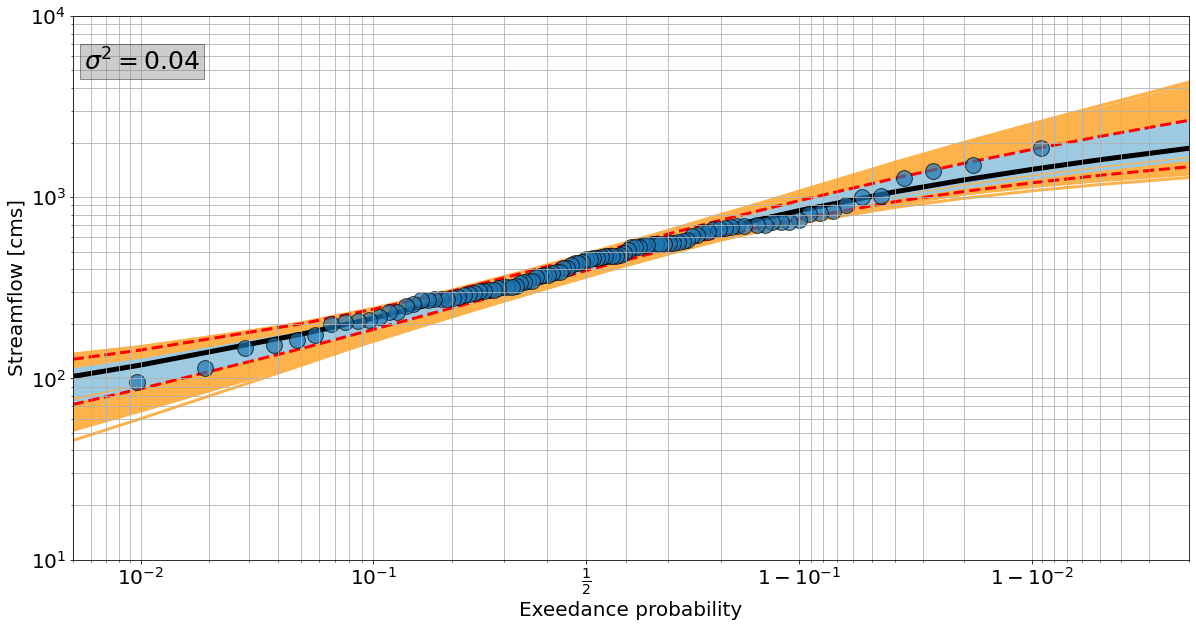

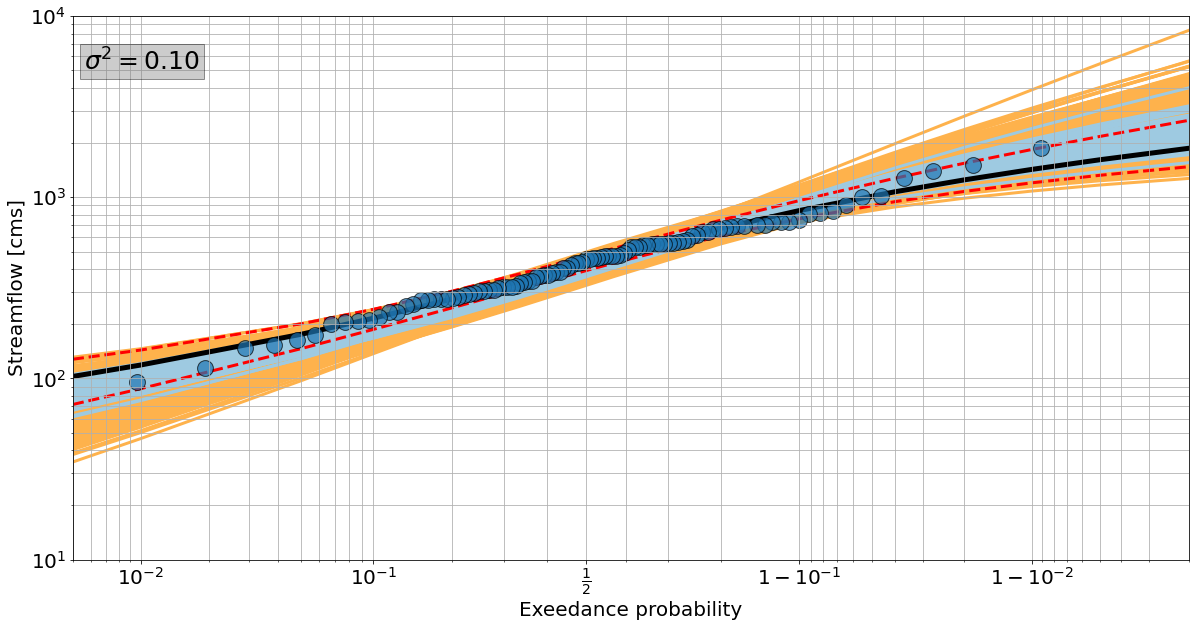

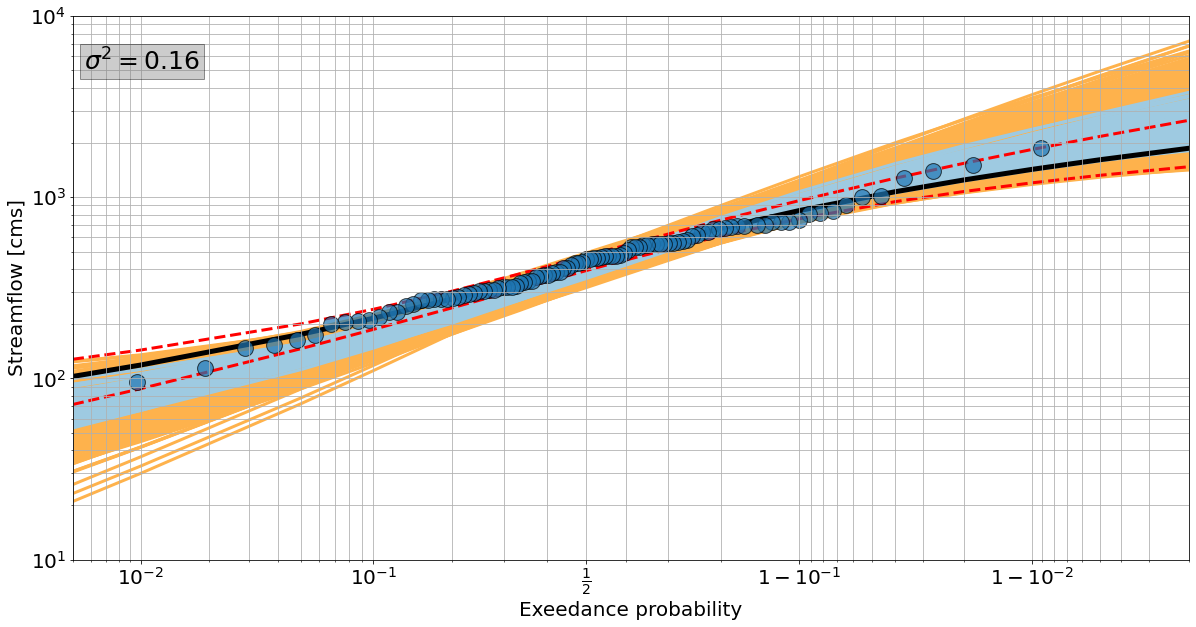

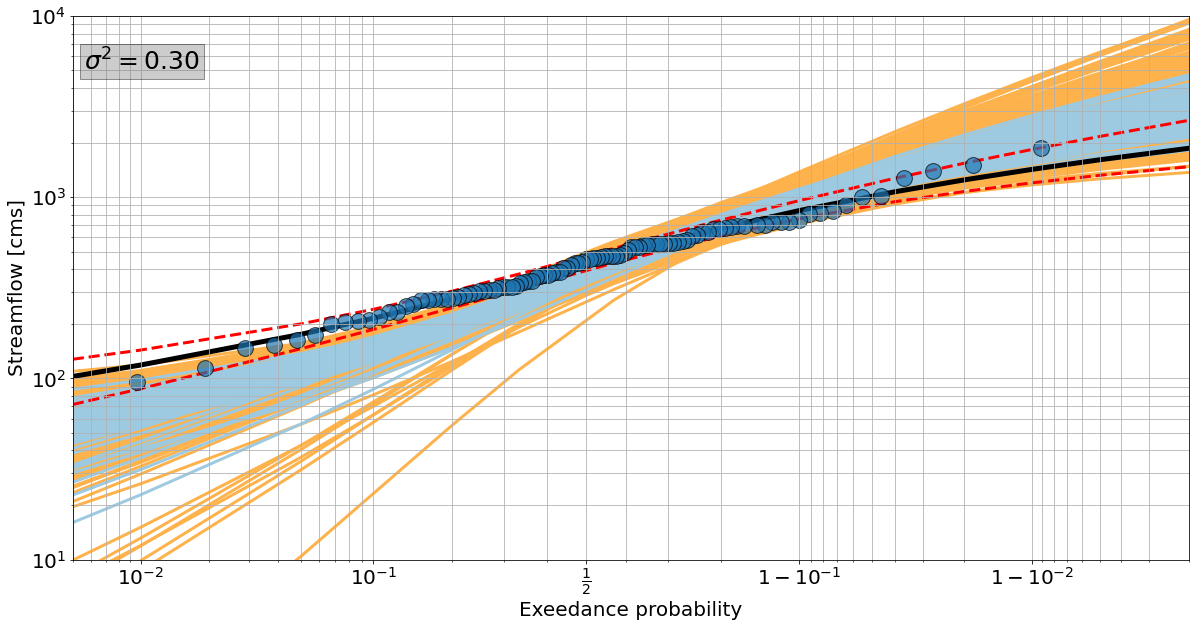

In [14]:
do = read_prt('05412500F-TURKEY.PRT')[0]
q,ema,p = read_obs('05412500F-TURKEY.PRT')
for c,sigma in enumerate([0.04,0.1,0.16,0.3]):
    dn = read_prt('TURKEY_NOISED'+str(c)+'.PRT')
    ax = plot_freq(do, dn)
    text = '$\sigma^2 = %.2f$' % sigma
    ax.text(0.01,0.9, text, fontdict = {'size': 25, 'weight':'bold'}, transform = ax.transAxes,
        bbox=dict(facecolor='gray', alpha=0.4)) 
    ax.set_ylim(10e0, 10e3)    
    ax.scatter(1-ema, q*0.028, s = 250, edgecolor = 'k', zorder = 1, alpha = 0.7)

## Cedar River at Cedar Rapids (16860.82 $km^2$) - 119 Years of records

In [871]:
fix_year_issue('05464500-cedar.txt','05464500f-cedar.txt')
for c,sigma in enumerate([0.04,0.1,0.16,0.3]):
    qo,qn = qp_noise('05464500f-cedar.txt','cedar_peaks'+str(c)+'.txt',
                 'cedar_noised'+str(c)+'.psf','cedar_noised'+str(c)+'.prt',100,-0.4,0.55,sigma, method = 'EMS')

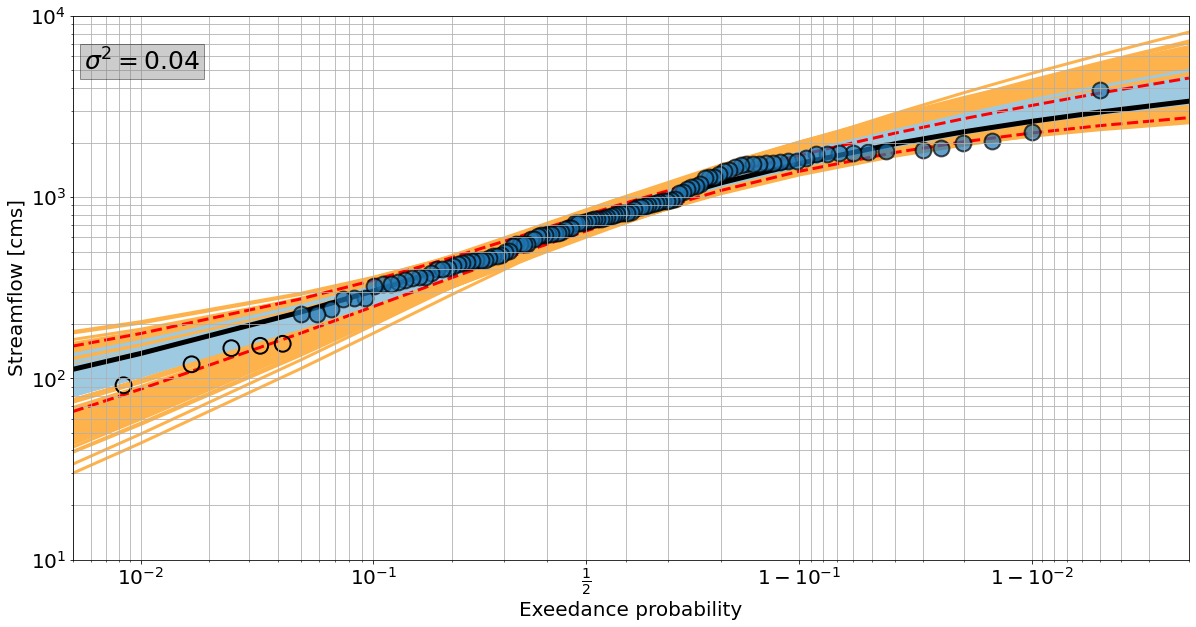

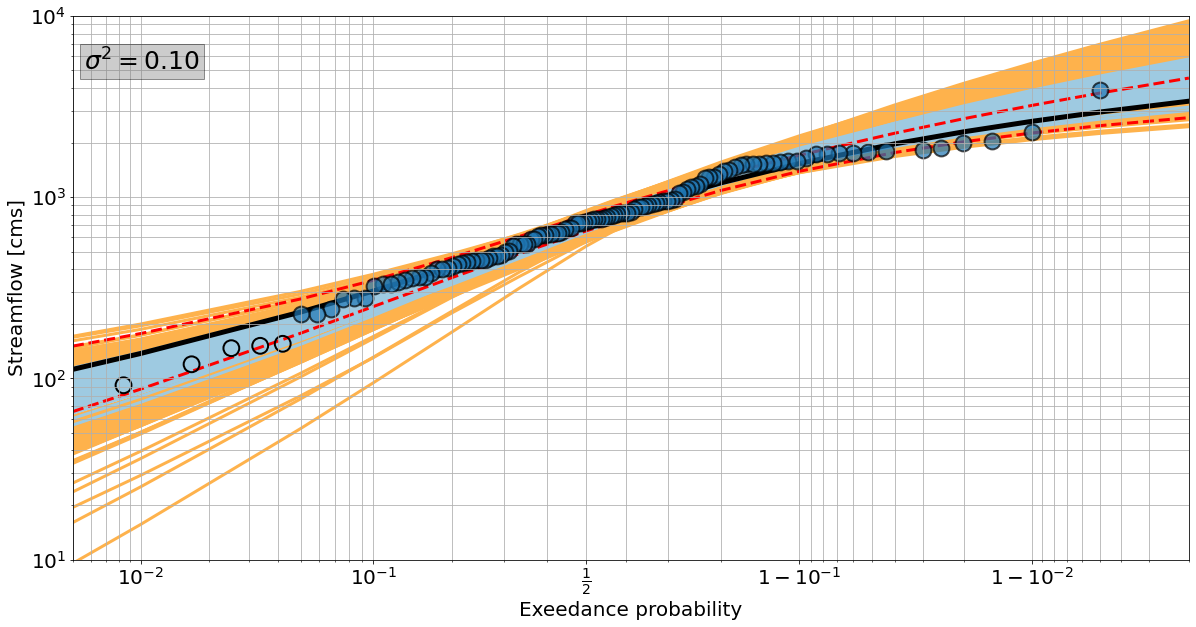

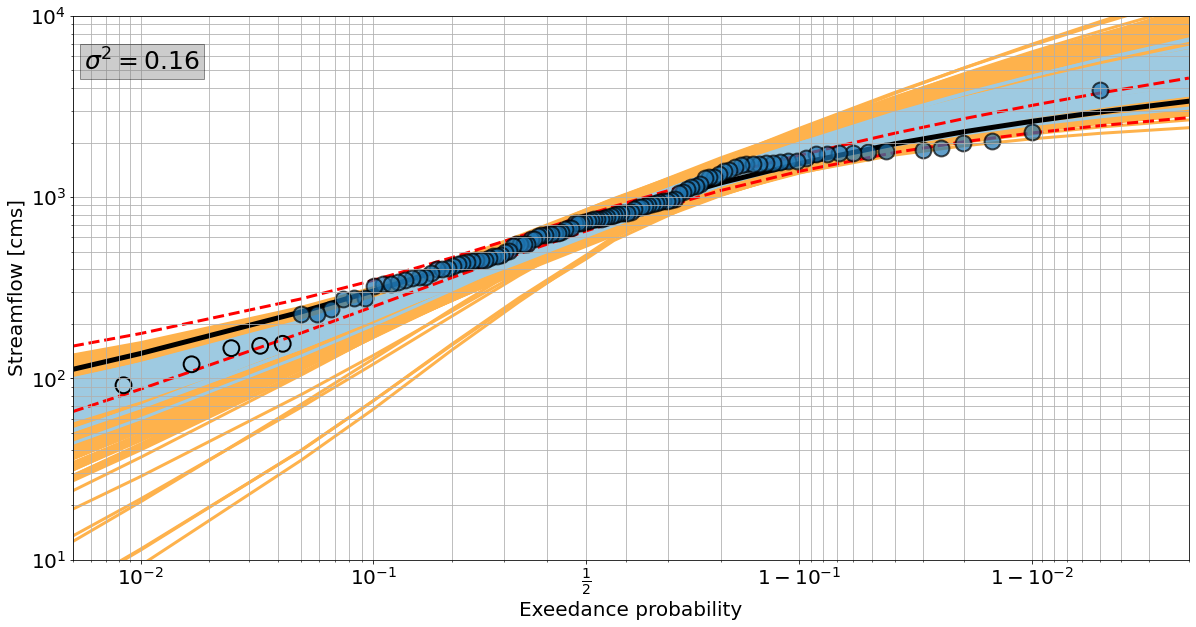

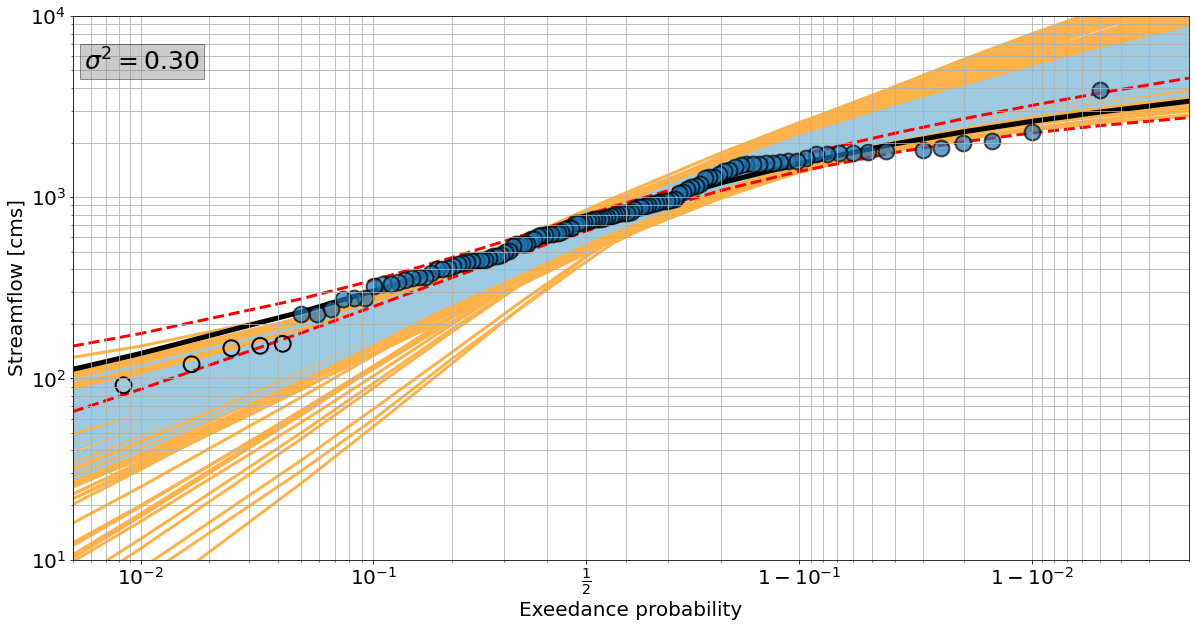

In [970]:
do = read_prt('05464500-CEDAR.PRT')[0]
q,ema,pilf = read_obs('05464500-CEDAR.PRT')
for c,sigma in enumerate([0.04,0.1,0.16,0.3]):
    dn = read_prt('CEDAR_NOISED'+str(c)+'.PRT')
    ax = plot_freq(do, dn)
    text = '$\sigma^2 = %.2f$' % sigma
    ax.text(0.01,0.9, text, fontdict = {'size': 25, 'weight':'bold'}, transform = ax.transAxes,
        bbox=dict(facecolor='gray', alpha=0.4)) 
    ax.set_ylim(10e1,10e3)
    ax.set_ylim(10e0, 10e3)    
    pos = np.where(pilf == 0)
    ax.scatter(1-ema[pos], q[pos]*0.028, s = 250, edgecolor = 'k', zorder = 1, alpha = 0.7, lw = 2)
    if len(pos) > 0:
        pos = np.where(pilf == 1)
        ax.scatter(1-ema[pos], q[pos]*0.028, s = 250, edgecolor = 'k', zorder = 1, facecolor='none', lw = 2)

## North Racoon (2000 $km^2$) - 80 records

In [884]:
fix_year_issue('05482500-NorthRacoon.txt','05482500f-NorthRacoon.txt')
for c,sigma in enumerate([0.04,0.1,0.16,0.3]):
    qo,qn = qp_noise('05482500f-NorthRacoon.txt','nracoon_peaks'+str(c)+'.txt',
                 'nracoon_noised'+str(c)+'.psf','nracoon_noised'+str(c)+'.prt',100,-0.3919,0.55,sigma, method = 'EMS')

In [74]:
a = write_mutated_peaks('05482500f-NorthRacoon.txt','NorthRacoon_50y_NoiseDep.txt',
             'NorthRacoon_50y_NoiseDep.psf','NorthRacoon_50y_NoiseDep.prt',50,100, -0.3919,0.55,sigma, method = 'EMS',
                    error = 0.05, add_noise=True)

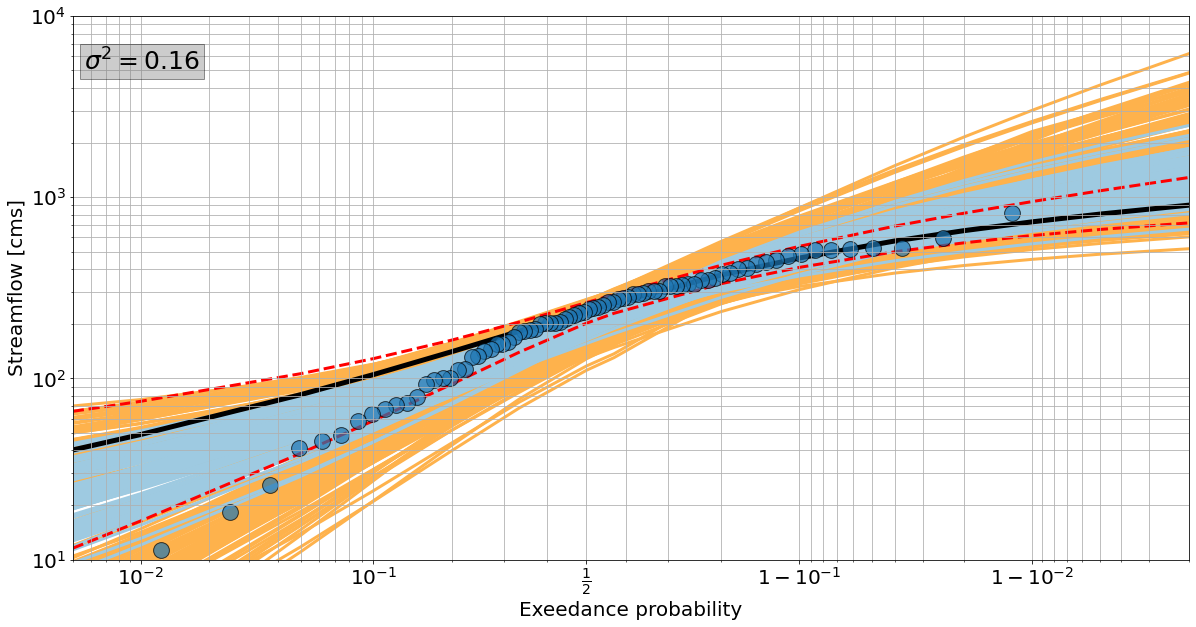

In [72]:
do = read_prt('05482500F-NORTHRACOON.PRT')[0]
q,ema,pilf = read_obs('05482500F-NORTHRACOON.PRT')
dn = read_prt('NORTHRACOON_50Y_NOISEDEP.PRT')
ax = plot_freq(do, dn)
text = '$\sigma^2 = %.2f$' % sigma
ax.text(0.01,0.9, text, fontdict = {'size': 25, 'weight':'bold'}, transform = ax.transAxes,
    bbox=dict(facecolor='gray', alpha=0.4)) 
ax.set_ylim(10e0, 10e3)    
ax.scatter(1-ema, q*0.028, s = 250, edgecolor = 'k', zorder = 1, alpha = 0.7)

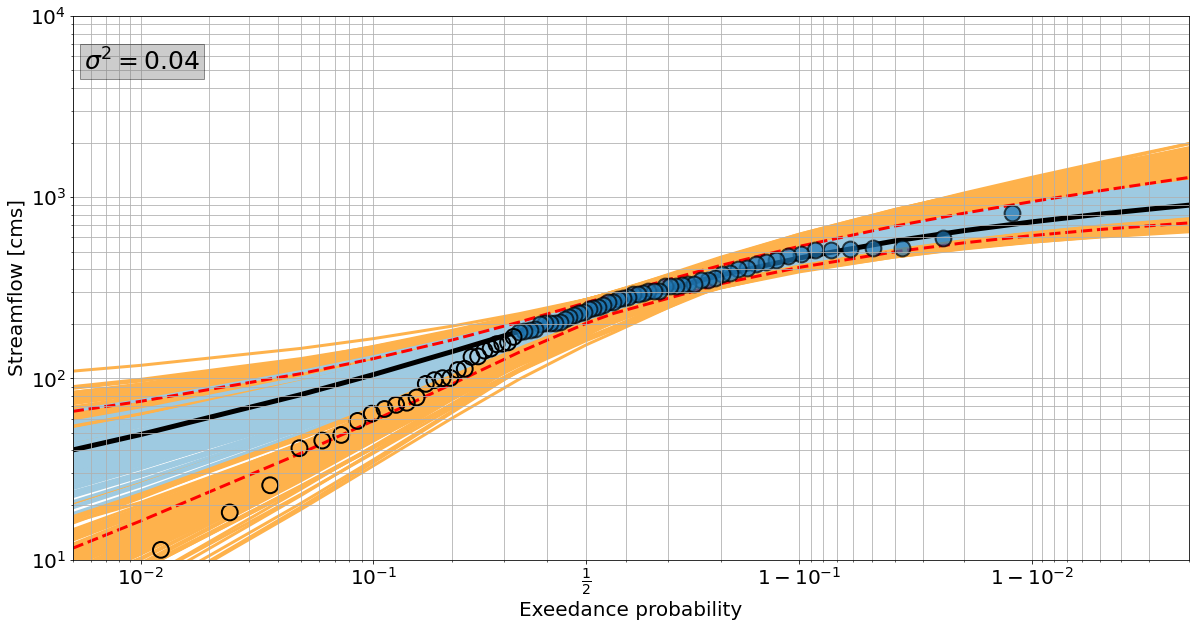

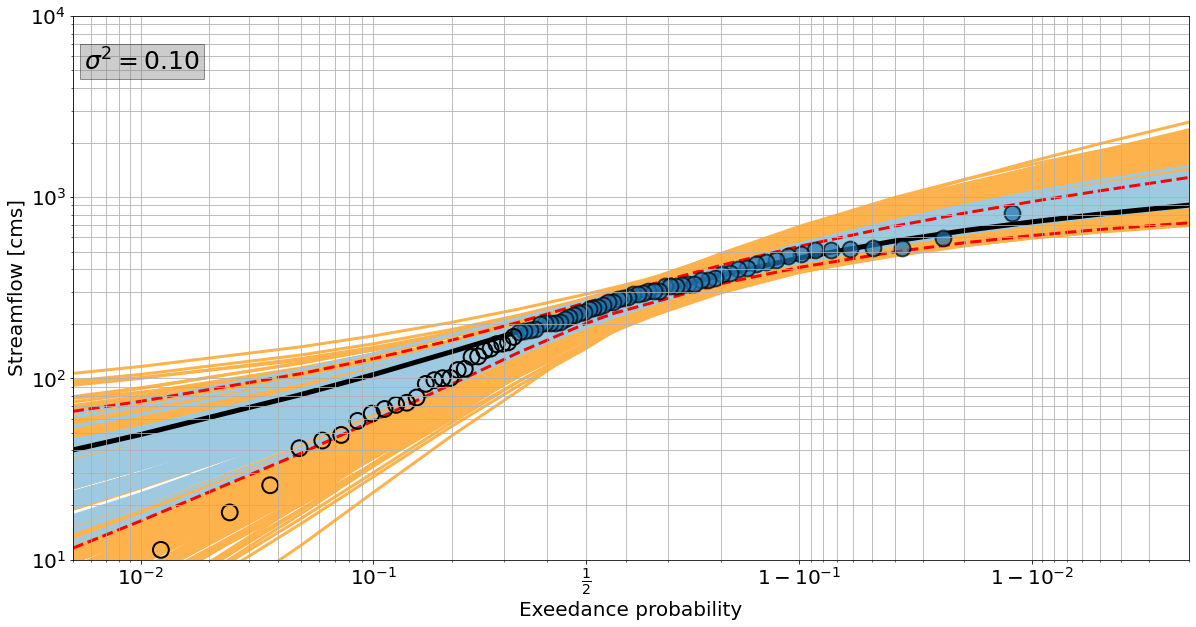

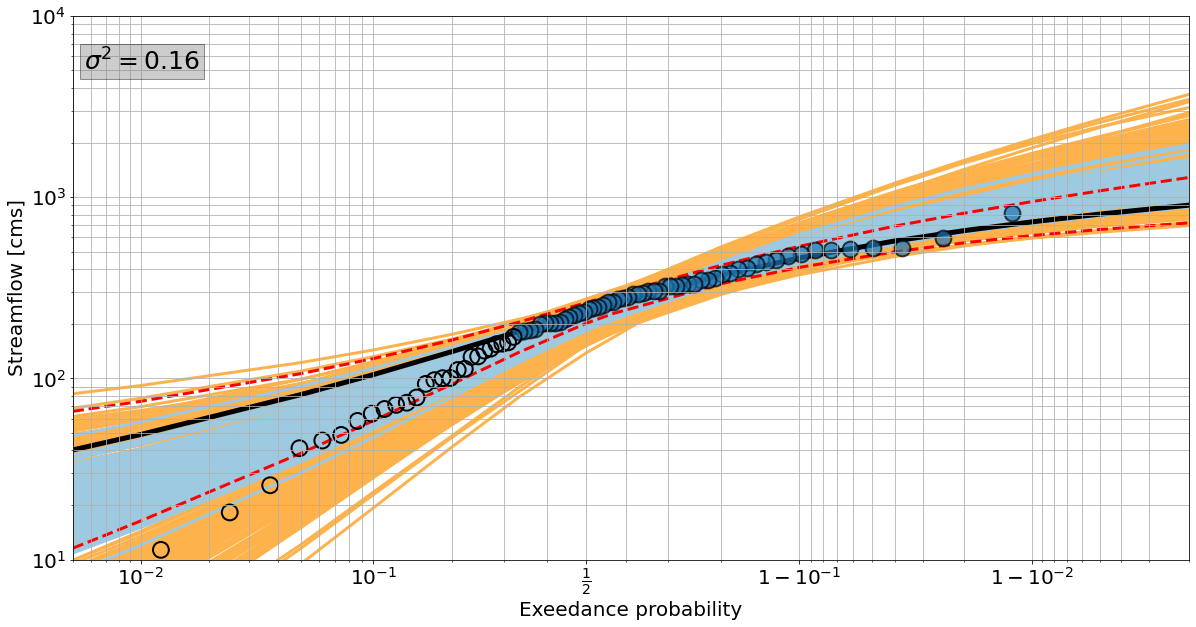

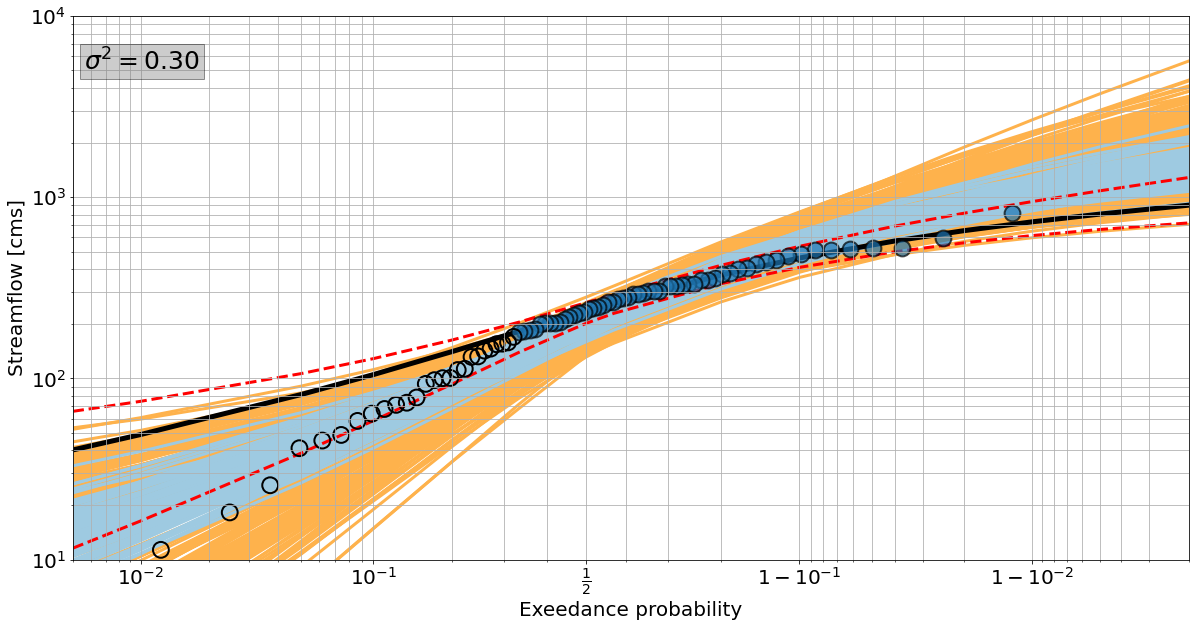

In [973]:
do = read_prt('05482500F-NORTHRACOON.PRT')[0]
q,ema,pilf = read_obs('05482500F-NORTHRACOON.PRT')
for c,sigma in enumerate([0.04,0.1,0.16,0.3]):
    dn = read_prt('NRACOON_NOISED'+str(c)+'.PRT')
    ax = plot_freq(do, dn)
    text = '$\sigma^2 = %.2f$' % sigma
    ax.text(0.01,0.9, text, fontdict = {'size': 25, 'weight':'bold'}, transform = ax.transAxes,
        bbox=dict(facecolor='gray', alpha=0.4))    
    ax.set_ylim(10e0,10e3)
    pos = np.where(pilf == 0)
    ax.scatter(1-ema[pos], q[pos]*0.028, s = 250, edgecolor = 'k', zorder = 1, alpha = 0.7, lw = 2)
    if len(pos) > 0:
        pos = np.where(pilf == 1)
        ax.scatter(1-ema[pos], q[pos]*0.028, s = 250, edgecolor = 'k', zorder = 1, facecolor='none', lw = 2)

## Platte (500$km^2$) - 48 years of record 

In [975]:
fix_year_issue('06818750-platte.txt','06818750f-platte.txt')
for c,sigma in enumerate([0.04,0.1,0.16,0.3]):
    qo,qn = qp_noise('06818750f-platte.txt','platte_peaks'+str(c)+'.txt',
                 'platte_noised'+str(c)+'.psf','platte_noised'+str(c)+'.prt',100,-0.34376,0.55,sigma, method = 'EMS')

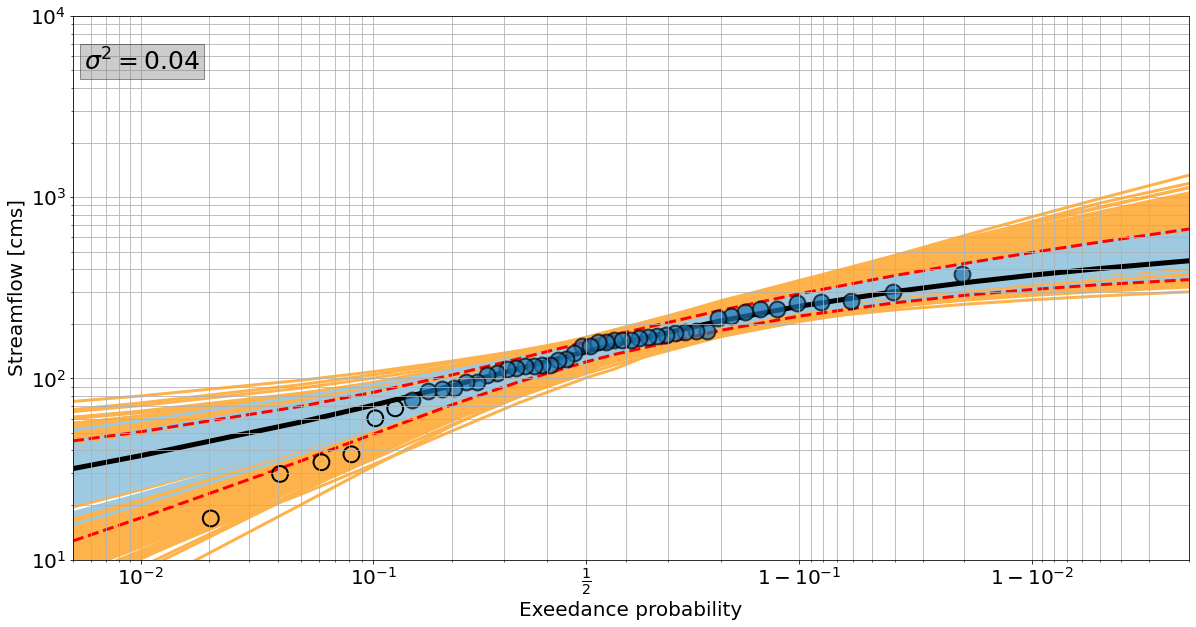

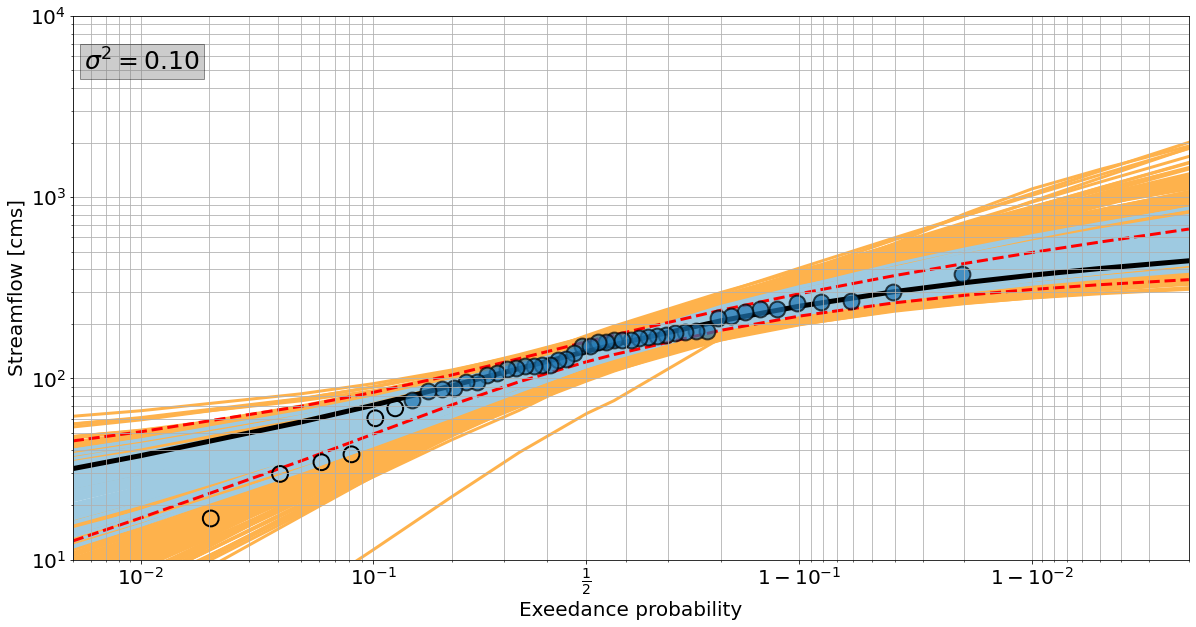

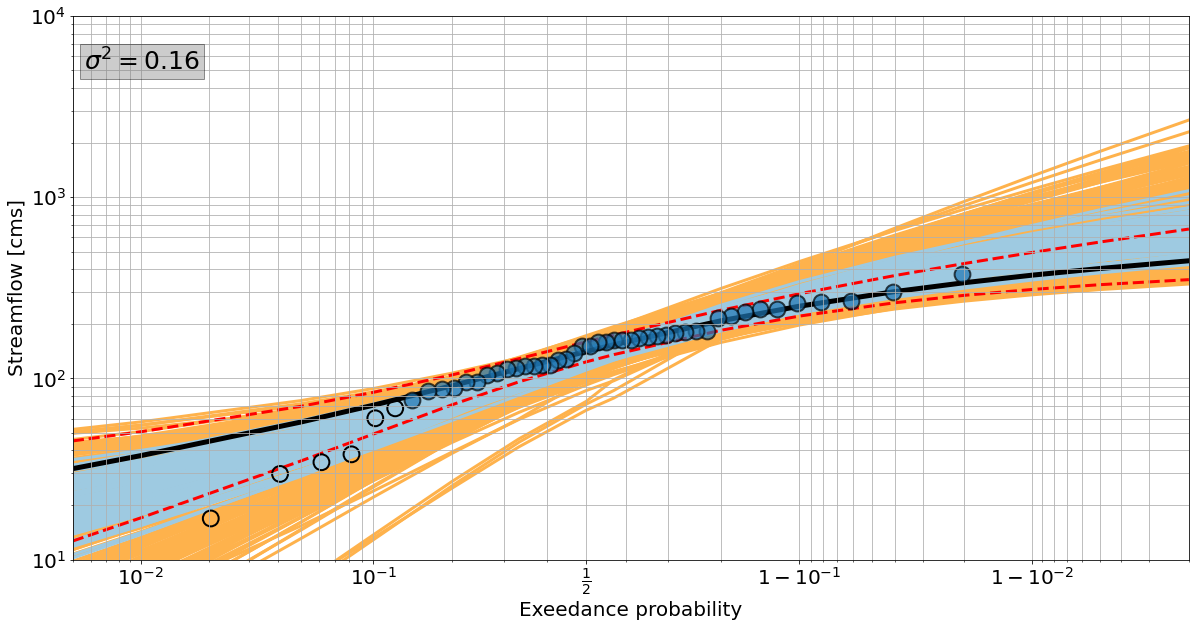

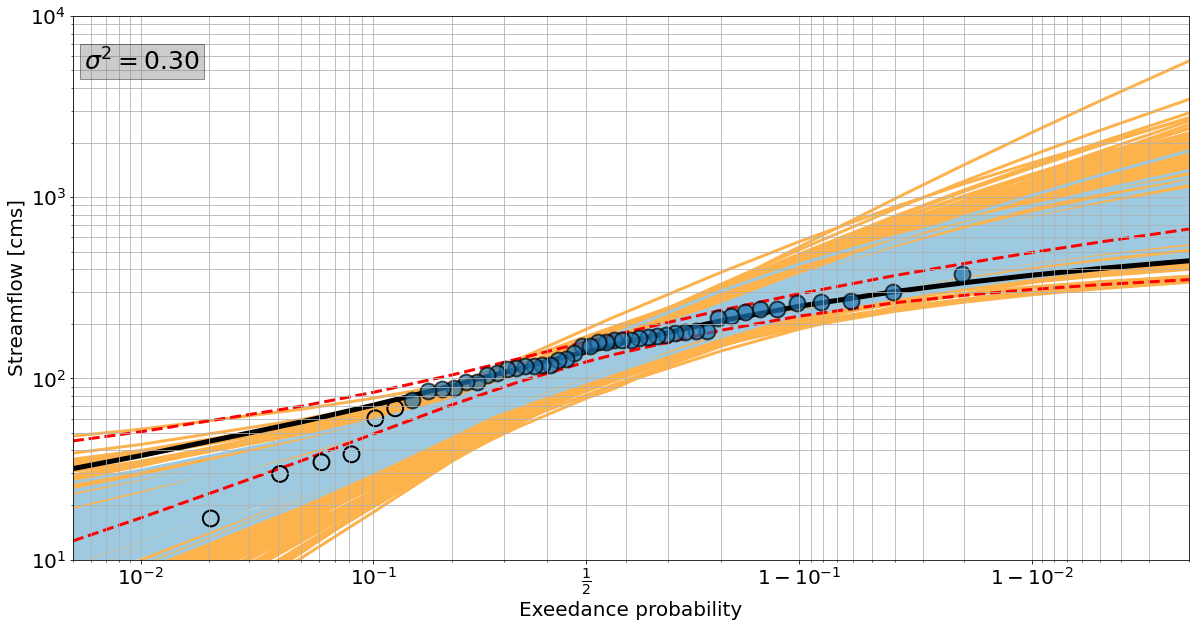

In [979]:
do = read_prt('06818750F-PLATTE.PRT')[0]
q,ema,pilf = read_obs('06818750F-PLATTE.PRT')
for c,sigma in enumerate([0.04,0.1,0.16,0.3]):
    dn = read_prt('PLATTE_NOISED'+str(c)+'.PRT')
    ax = plot_freq(do, dn)
    text = '$\sigma^2 = %.2f$' % sigma
    ax.text(0.01,0.9, text, fontdict = {'size': 25, 'weight':'bold'}, transform = ax.transAxes,
        bbox=dict(facecolor='gray', alpha=0.4))    
    ax.set_ylim(10e0,10e3)
    pos = np.where(pilf == 0)
    ax.scatter(1-ema[pos], q[pos]*0.028, s = 250, edgecolor = 'k', zorder = 1, alpha = 0.7, lw = 2)
    if len(pos) > 0:
        pos = np.where(pilf == 1)
        ax.scatter(1-ema[pos], q[pos]*0.028, s = 250, edgecolor = 'k', zorder = 1, facecolor='none', lw = 2)